In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 设置绘图风格，让图表看起来更专业
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei'] # 解决中文显示问题

# 从 processed 路径加载
df_analysis = pd.read_csv(r'..\data\processed\mplus_S3_7_14_CLEANED.csv')

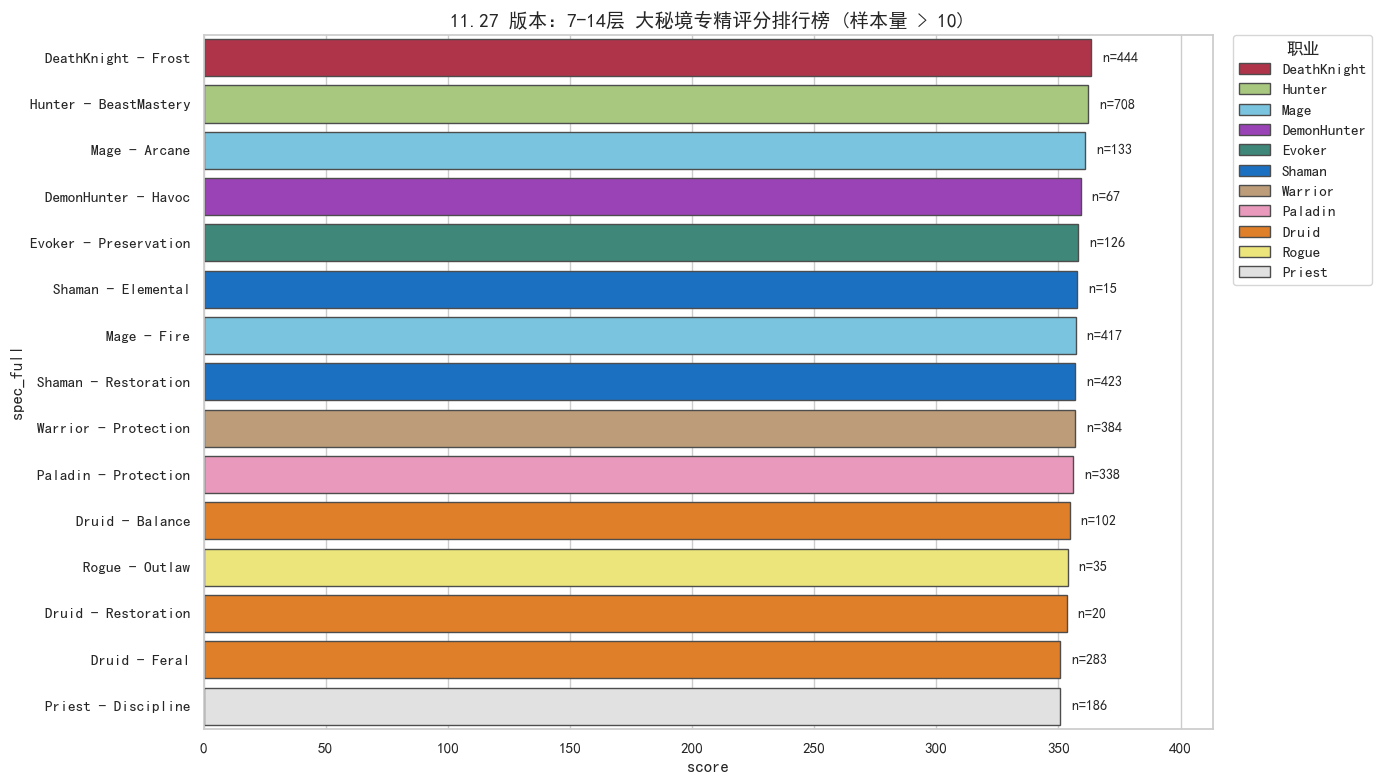

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 职业颜色映射（微调：将牧师改为浅灰色，确保可见）
wow_class_colors = {
    'Druid': '#FF7D0A', 'Warrior': '#C79C6E', 'Paladin': '#F58CBA',
    'Priest': '#E1E1E1',  # 👈 这里从 #FFFFFF 改为浅灰色，解决“隐身”问题
    'Shaman': '#0070DE', 'Mage': '#69CCF0',
    'Warlock': '#9482C9', 'Monk': '#00FF96', 'Rogue': '#FFF569',
    'DeathKnight': '#C41F3B', 'DemonHunter': '#A330C9', 'Hunter': '#ABD473',
    'Evoker': '#33937F'
}

# 2. 核心逻辑：层级筛选 + 标签合并
target_keys = df_analysis[(df_analysis['level'] >= 7) & (df_analysis['level'] <= 14)].copy()
target_keys['spec_full'] = target_keys['class_name'] + " - " + target_keys['spec_name']

# 3. 统计计算：平均分与场次
spec_performance = target_keys.groupby(['class_name', 'spec_full']).agg({
    'score': 'mean',
    'level': 'count'
}).rename(columns={'level': 'count'}).reset_index()

# 4. 样本量过滤
spec_performance = spec_performance[spec_performance['count'] >= 10].sort_values(by='score', ascending=False)

# 5. 可视化：Top 15 强力专精
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=spec_performance.head(15), 
    x='score', 
    y='spec_full', 
    hue='class_name', 
    dodge=False, 
    palette=wow_class_colors,
    edgecolor='0.3' # 👈 这里增加了细灰边框，让白色条形有轮廓感
)

# 6. 核心修复：清理“脏东西”并解决标注重叠
# 我们改用 width + 5，并确保文本始终在柱子外部
for i, p in enumerate(ax.patches):
    width = p.get_width()
    if width > 0: 
        count_val = spec_performance.iloc[i]['count']
        ax.text(width + 2, p.get_y() + p.get_height() / 2, 
                f' n={count_val}', 
                va='center', fontsize=10, fontweight='bold')

# 7. 布局优化
plt.legend(title='职业', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.title('11.27 版本：7-14层 大秘境专精评分排行榜 (样本量 > 10)', fontsize=14)
plt.xlim(0, spec_performance['score'].max() + 50) # 👈 留出右侧空间给 n=xxx 文本
plt.tight_layout() 
plt.show()

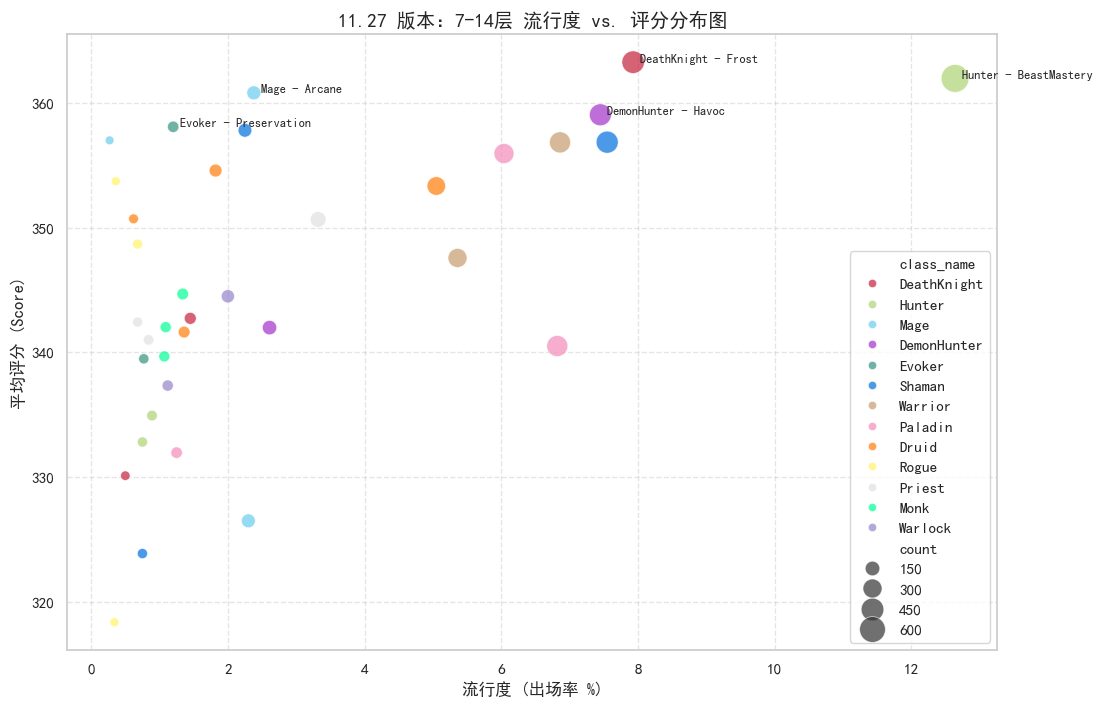

In [9]:
# 1. 计算每个专精的平均分和出场百分比（沿用你刚才的逻辑）
total_runs = len(target_keys)
spec_performance['popularity_%'] = (spec_performance['count'] / total_runs * 100).round(2)

# 2. 绘制散点图：横轴是出场率，纵轴是评分
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=spec_performance, 
    x='popularity_%', 
    y='score', 
    hue='class_name', 
    size='count',          # 样本量越大，点越大
    sizes=(40, 400), 
    palette=wow_class_colors,
    alpha=0.7
)

# 3. 为关键点加标签（比如前 5 名）
for i in range(min(5, len(spec_performance))):
    plt.text(
        spec_performance.iloc[i]['popularity_%'] + 0.1, 
        spec_performance.iloc[i]['score'], 
        spec_performance.iloc[i]['spec_full'], 
        fontsize=9
    )

plt.title('11.27 版本：7-14层 流行度 vs. 评分分布图', fontsize=14)
plt.xlabel('流行度 (出场率 %)')
plt.ylabel('平均评分 (Score)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [10]:
# 1. 定义职责名单（基于数据表里的 spec_name 字段）
# 🛡️ 坦克：涵盖防骑、防战、血DK、熊、复仇、酒仙
tank_specs = ['Protection', 'Blood', 'Guardian', 'Vengeance', 'Brewmaster']

# 💚 治疗：涵盖神牧、奶骑、奶德、奶萨、奶龙、奶僧、戒律
healer_specs = ['Holy', 'Restoration', 'Preservation', 'Mistweaver', 'Discipline']

# 2. 数据切片（基于你之前筛选的 7-14 层基准 target_keys）
df_tank = target_keys[target_keys['spec_name'].isin(tank_specs)].copy()
df_healer = target_keys[target_keys['spec_name'].isin(healer_specs)].copy()

# ⚔️ 输出(DPS)：排除掉上面两类，剩下的 26 个全是输出（包括暗牧、增辉等）
df_dps = target_keys[~target_keys['spec_name'].isin(tank_specs + healer_specs)].copy()

# 3. 快速自检
print(f"📊 职责分流统计：")
print(f" - ⚔️ DPS 专精: {df_dps['spec_name'].nunique()} 个 (应为26)")
print(f" - 🛡️ 坦克专精: {df_tank['spec_name'].nunique() + 1} 个 (Protection计2次，应为6)")
print(f" - 💚 治疗专精: {df_healer['spec_name'].nunique() + 2} 个 (Holy/Restoration各计2次，应为7)")

📊 职责分流统计：
 - ⚔️ DPS 专精: 25 个 (应为26)
 - 🛡️ 坦克专精: 6 个 (Protection计2次，应为6)
 - 💚 治疗专精: 7 个 (Holy/Restoration各计2次，应为7)


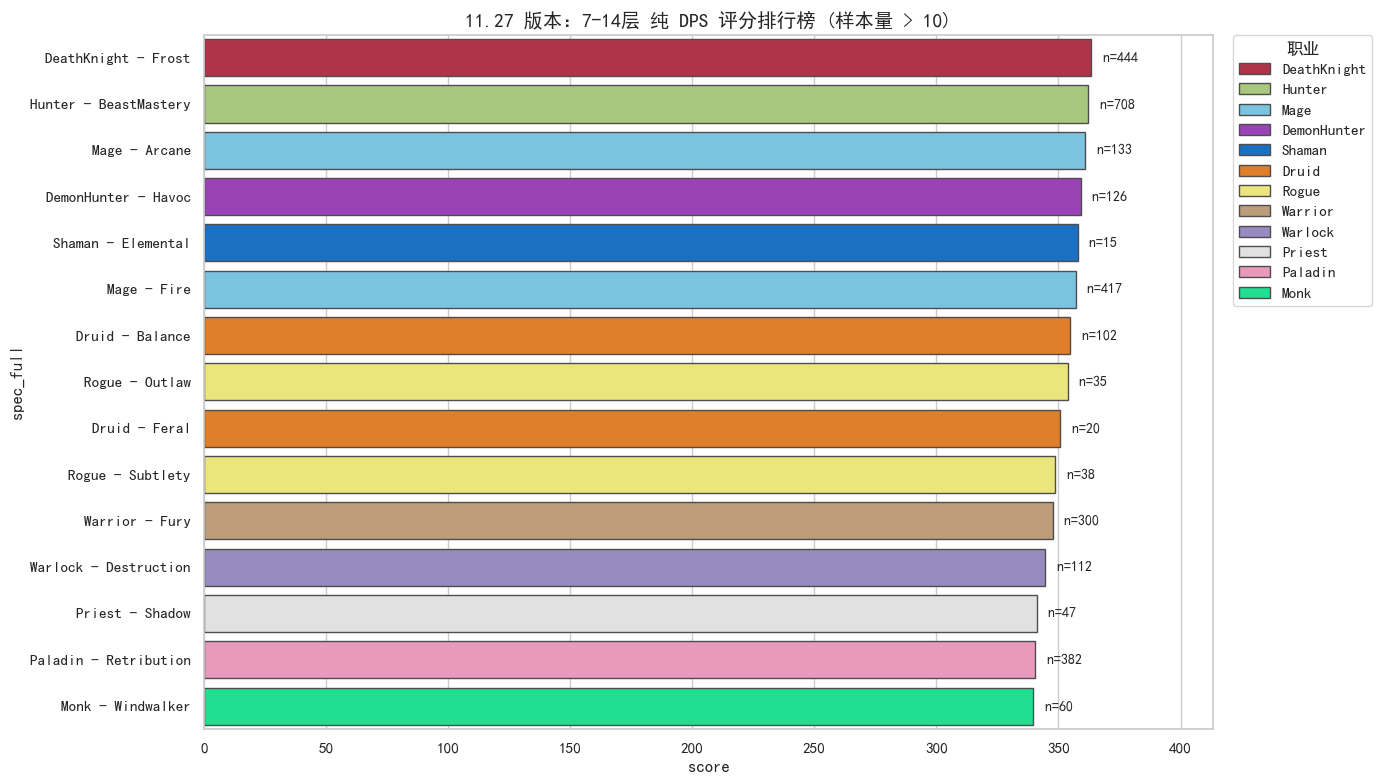

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 职业颜色映射（牧师微调为浅灰，增加可见度）
wow_class_colors = {
    'Druid': '#FF7D0A', 'Warrior': '#C79C6E', 'Paladin': '#F58CBA',
    'Priest': '#E1E1E1', 
    'Shaman': '#0070DE', 'Mage': '#69CCF0',
    'Warlock': '#9482C9', 'Monk': '#00FF96', 'Rogue': '#FFF569',
    'DeathKnight': '#C41F3B', 'DemonHunter': '#A330C9', 'Hunter': '#ABD473',
    'Evoker': '#33937F'
}

# 2. 统计计算：仅针对你刚才分流出的 df_dps 
# 确保之前分流 df_dps 的 cell 已经运行成功
dps_performance = df_dps.groupby(['class_name', 'spec_full']).agg({
    'score': 'mean',
    'level': 'count'
}).rename(columns={'level': 'count'}).reset_index()

# 3. 稳健性过滤：样本量 n >= 10
dps_performance = dps_performance[dps_performance['count'] >= 10].sort_values(by='score', ascending=False)

# 4. 可视化：Top 15 纯输出专精排行榜
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=dps_performance.head(15), 
    x='score', 
    y='spec_full', 
    hue='class_name', 
    dodge=False, 
    palette=wow_class_colors,
    edgecolor='0.3' 
)

# 5. 核心修复：清理标注位置，解决 DK 条上的“脏东西”
for i, p in enumerate(ax.patches):
    width = p.get_width()
    if width > 0: 
        count_val = dps_performance.iloc[i]['count']
        ax.text(width + 2, p.get_y() + p.get_height() / 2, 
                f' n={count_val}', 
                va='center', fontsize=10, fontweight='bold')

# 6. 布局与图例优化
plt.legend(title='职业', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.title('11.27 版本：7-14层 纯 DPS 评分排行榜 (样本量 > 10)', fontsize=14)
plt.xlim(0, dps_performance['score'].max() + 50) 
plt.tight_layout() 
plt.savefig('../figures/dps_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

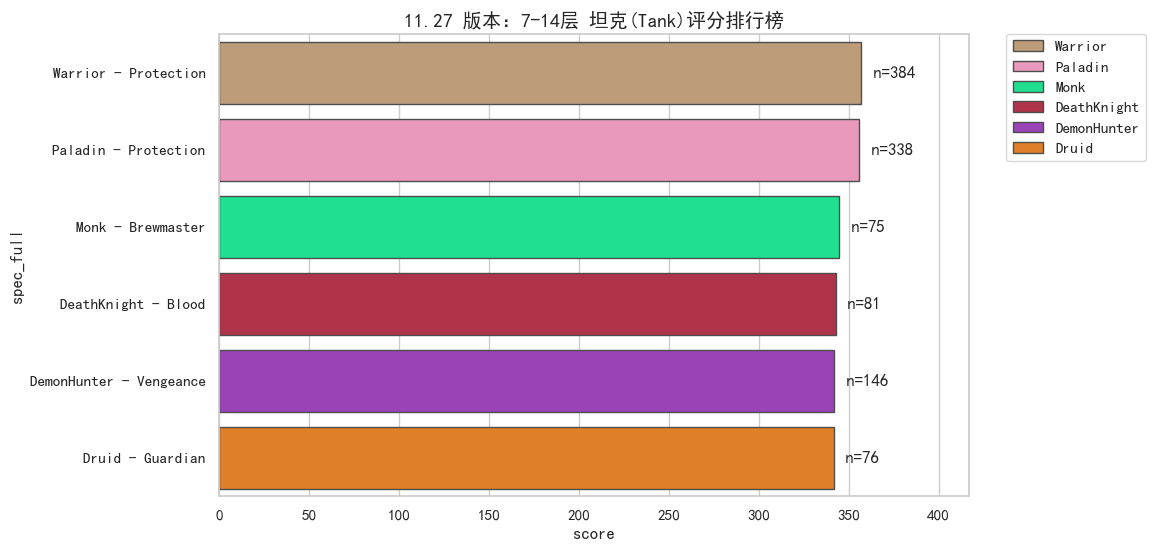

In [18]:
# 1. 统计坦克表现
tank_stats = df_tank.groupby(['class_name', 'spec_full']).agg({
    'score': 'mean',
    'level': 'count'
}).rename(columns={'level': 'count'}).reset_index()

# 过滤样本并排序
tank_stats = tank_stats[tank_stats['count'] >= 10].sort_values(by='score', ascending=False)

# 2. 绘图
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=tank_stats, x='score', y='spec_full', hue='class_name', 
                 palette=wow_class_colors, edgecolor='0.3', dodge=False)

# 3. 修复 IndexError 的核心改动：使用 zip 确保一一对应
# 这样标注只会匹配实际存在的柱子
for p, (index, row) in zip(ax.patches, tank_stats.iterrows()):
    ax.text(p.get_width() + 2, p.get_y() + p.get_height()/2, 
            f' n={int(row["count"])}', va='center', fontweight='bold')

# 4. 彻底解决图例重合：手动缩小绘图比例，给图例留出右侧空间
plt.title('11.27 版本：7-14层 坦克(Tank)评分排行榜', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlim(0, tank_stats['score'].max() + 60)
plt.subplots_adjust(right=0.75) # 👈 关键修复：强制给右侧留出 25% 的空白空间
plt.savefig('../figures/tank_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

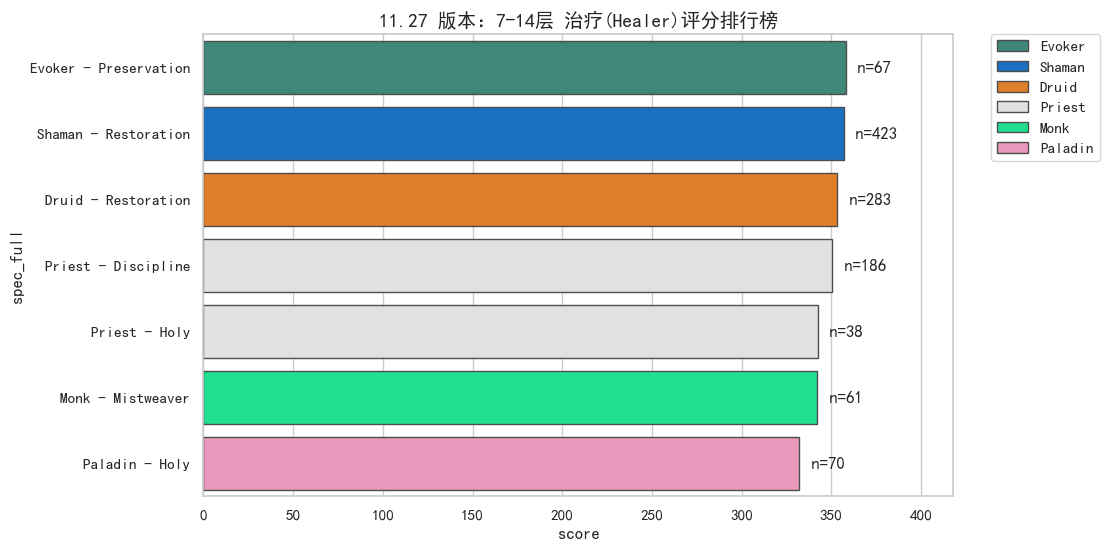

In [19]:
# 1. 统计治疗表现
healer_stats = df_healer.groupby(['class_name', 'spec_full']).agg({
    'score': 'mean',
    'level': 'count'
}).rename(columns={'level': 'count'}).reset_index()

healer_stats = healer_stats[healer_stats['count'] >= 10].sort_values(by='score', ascending=False)

# 2. 绘图
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=healer_stats, x='score', y='spec_full', hue='class_name', 
                 palette=wow_class_colors, edgecolor='0.3', dodge=False)

# 3. 标注场次
for p, (index, row) in zip(ax.patches, healer_stats.iterrows()):
    ax.text(p.get_width() + 2, p.get_y() + p.get_height()/2, 
            f' n={int(row["count"])}', va='center', fontweight='bold')

# 4. 布局优化
plt.title('11.27 版本：7-14层 治疗(Healer)评分排行榜', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlim(0, healer_stats['score'].max() + 60)
plt.subplots_adjust(right=0.75) 
plt.savefig('../figures/healer_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

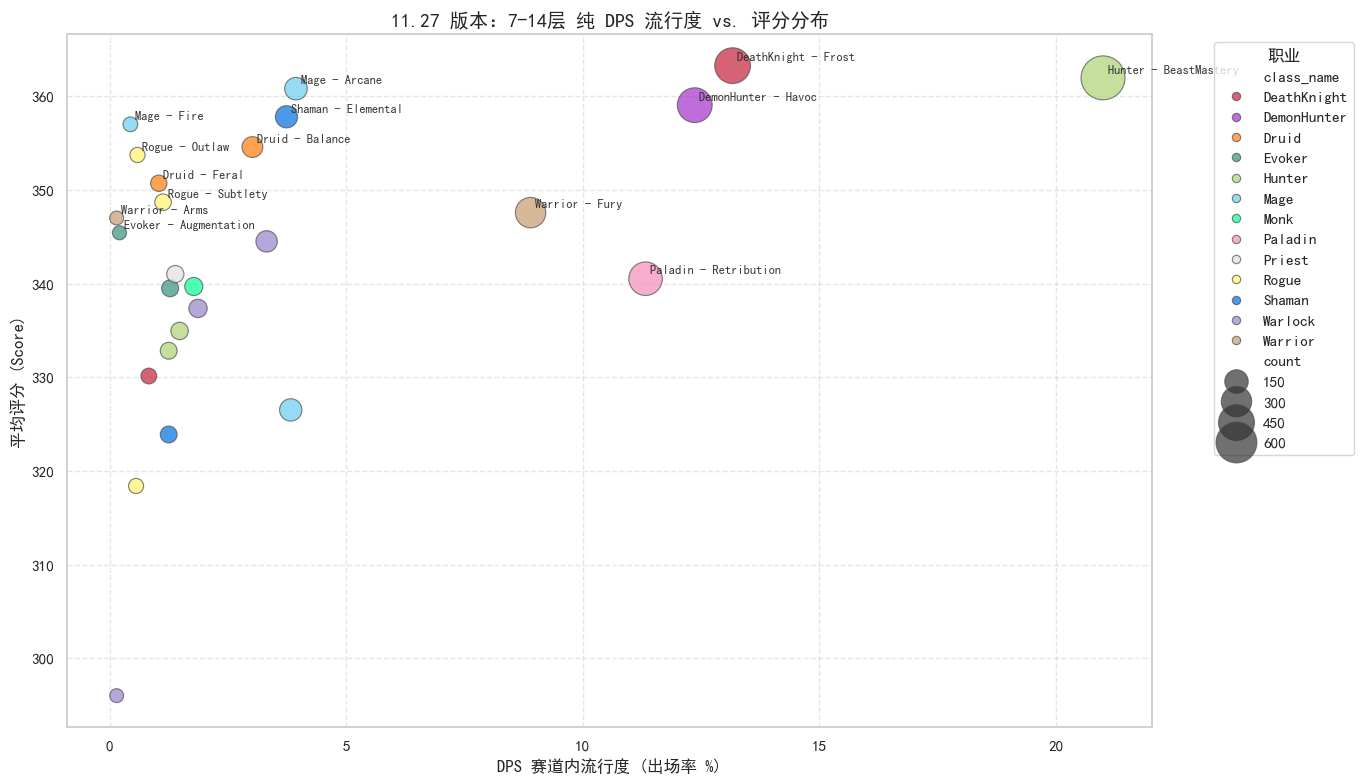

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 计算 DPS 内部的流行度百分比
total_dps_runs = len(df_dps)
dps_pop_stats = df_dps.groupby(['class_name', 'spec_full']).agg({
    'score': 'mean',
    'level': 'count'
}).rename(columns={'level': 'count'}).reset_index()

dps_pop_stats['popularity_%'] = (dps_pop_stats['count'] / total_dps_runs * 100).round(2)

# 2. 绘图
plt.figure(figsize=(14, 9))
sns.scatterplot(
    data=dps_pop_stats, x='popularity_%', y='score', 
    hue='class_name', size='count', sizes=(100, 1000),
    palette=wow_class_colors, alpha=0.7, edgecolor='0.3'
)

# 3. 智能标注：只标注出场率高或评分高的典型（如火法、暗牧、冰DK、兽王等）
# 这样图表在 GitHub 上看起来会非常专业
important_specs = dps_pop_stats[
    (dps_pop_stats['popularity_%'] > 5) | (dps_pop_stats['score'] > dps_pop_stats['score'].median())
]

for i in range(len(important_specs)):
    plt.text(
        important_specs.iloc[i]['popularity_%'] + 0.1, 
        important_specs.iloc[i]['score'] + 0.5, 
        important_specs.iloc[i]['spec_full'], 
        fontsize=9, alpha=0.9
    )

plt.title('11.27 版本：7-14层 纯 DPS 流行度 vs. 评分分布', fontsize=14)
plt.xlabel('DPS 赛道内流行度 (出场率 %)')
plt.ylabel('平均评分 (Score)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="职业")

# 4. 保存并显示（记得在 show 之前保存！）
plt.savefig('../figures/dps_pop_vs_score.png', dpi=300, bbox_inches='tight')
plt.show()

💾 图像已保存至: ../figures/tank_pop_vs_score.png


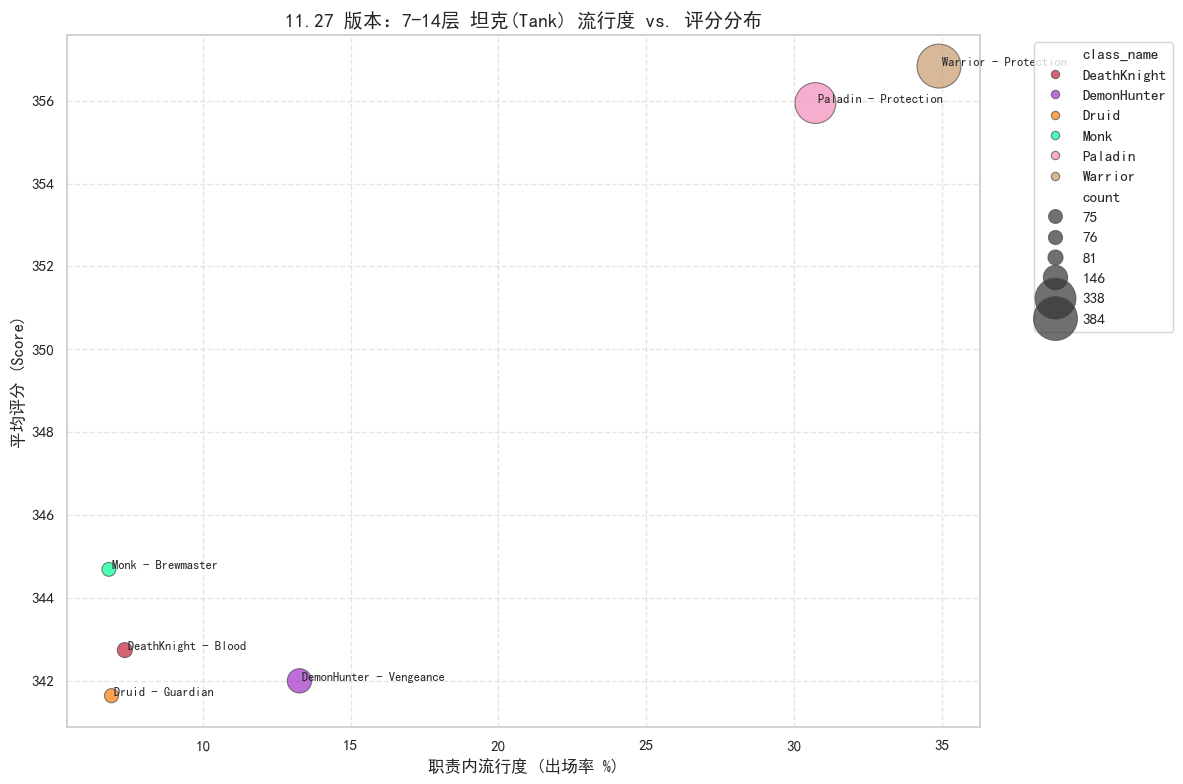

💾 图像已保存至: ../figures/healer_pop_vs_score.png


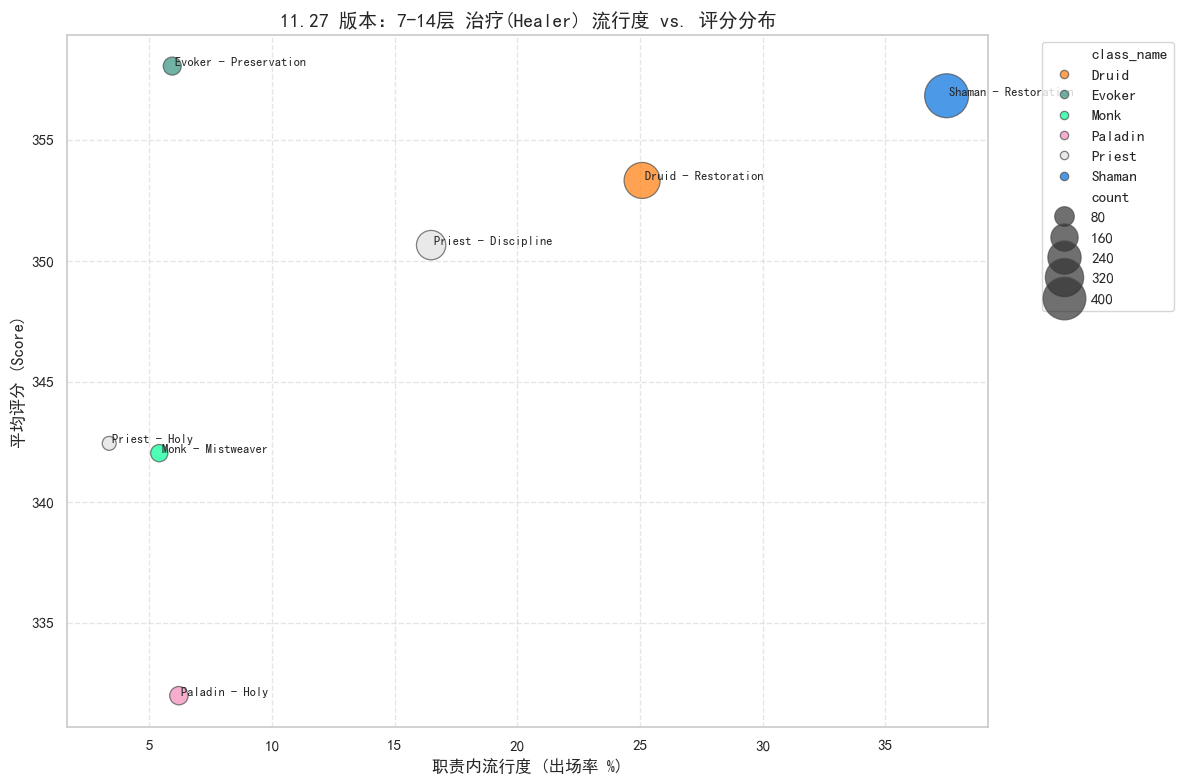

💾 图像已保存至: ../figures/dps_pop_vs_score.png


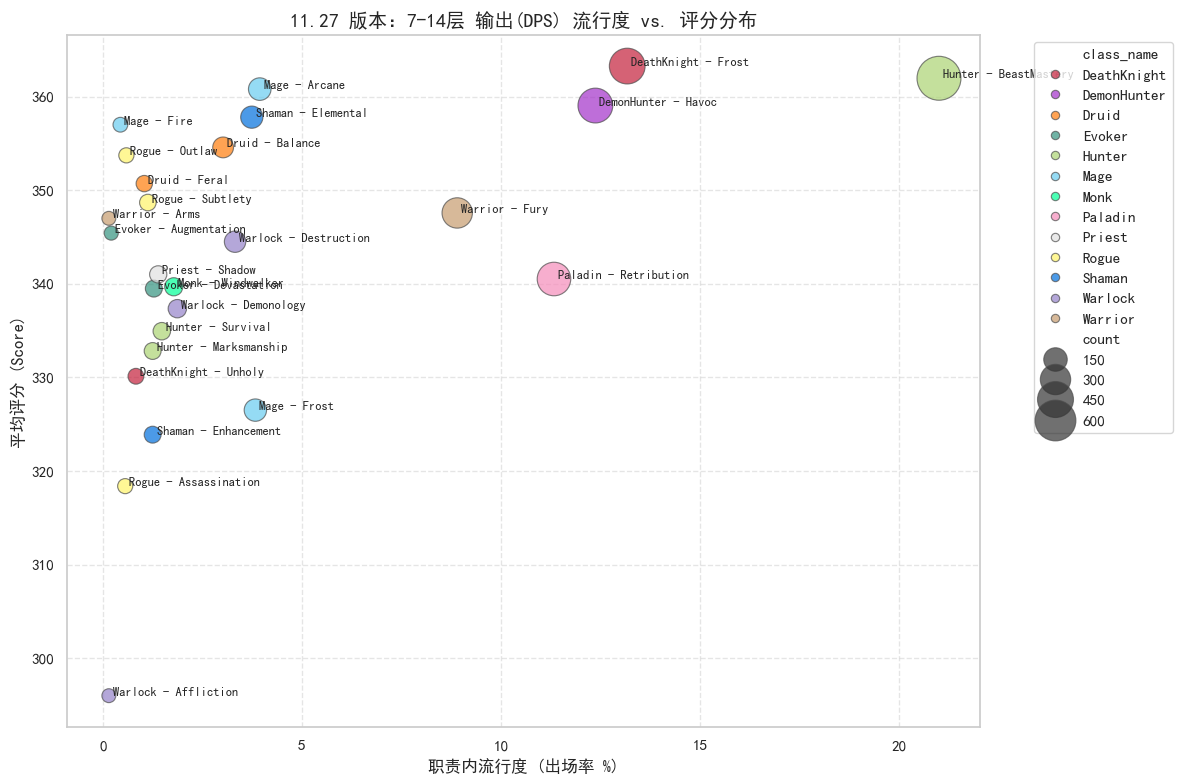

In [22]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

def plot_popularity_vs_score(df_target, title_suffix, filename):
    # 1. 计算职责内部的流行度百分比
    total_role_runs = len(df_target)
    stats = df_target.groupby(['class_name', 'spec_full']).agg({
        'score': 'mean',
        'level': 'count'
    }).rename(columns={'level': 'count'}).reset_index()
    
    stats['popularity_%'] = (stats['count'] / total_role_runs * 100).round(2)
    stats = stats[stats['count'] >= 5] 
    
    # 2. 绘图
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=stats, x='popularity_%', y='score', 
        hue='class_name', size='count', sizes=(100, 1000),
        palette=wow_class_colors, alpha=0.7, edgecolor='0.3'
    )
    
    # 3. 自动标注
    for i in range(len(stats)):
        plt.text(stats.iloc[i]['popularity_%'] + 0.1, stats.iloc[i]['score'], 
                 stats.iloc[i]['spec_full'], fontsize=9)

    plt.title(f'11.27 版本：7-14层 {title_suffix} 流行度 vs. 评分分布', fontsize=14)
    plt.xlabel('职责内流行度 (出场率 %)')
    plt.ylabel('平均评分 (Score)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 4. 核心改动：在 plt.show() 之前保存
    save_path = f'../figures/{filename}'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"💾 图像已保存至: {save_path}")
    
    plt.tight_layout()
    plt.show()

# --- 调用示例 ---
# 运行坦克散点图
plot_popularity_vs_score(df_tank, "坦克(Tank)", "tank_pop_vs_score.png")

# 运行治疗散点图
plot_popularity_vs_score(df_healer, "治疗(Healer)", "healer_pop_vs_score.png")

# 运行 DPS 散点图
plot_popularity_vs_score(df_dps, "输出(DPS)", "dps_pop_vs_score.png")